In [1]:
!pip install -U -q numpy scikit-learn pandas xgboost lightgbm category_encoders matplotlib seaborn cloudpickle shap

In [ ]:
# REPRODUCIBILITY: Set all random seeds before any other imports
import numpy as np
import random
import os

# Set all random seeds for full reproducibility
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'

# For XGBoost and other threaded libraries
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

print("✅ All random seeds set for reproducibility")

In [2]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
import pandas as pd

# Assume a dummy year since it's not provided
year = 2023

# Construct datetime from day_of_year and hour
train_df['datetime'] = pd.to_datetime(train_df['day_of_year'], format='%j', errors='coerce') \
                       + pd.to_timedelta(train_df['hour'], unit='h')
train_df['datetime'] = train_df['datetime'].apply(
    lambda dt: dt.replace(year=year) if pd.notnull(dt) else dt
)

# Sort by datetime column
train_df = train_df.sort_values(by='datetime')

# Drop the temporary datetime column
train_df = train_df.drop(columns='datetime')

train_df.reset_index(drop=True, inplace=True) # CRUCIAL #

In [ ]:
X_train = train_df.drop([
    "id",
    "pollution_value"], axis=1)
X_train_before = X_train.copy()
X_test = test_df.drop("id", axis=1).copy()

### fg 1-4 inclusive => 0.7200 val score on TimeSeriesSplit with 5 folds
### fg 1-5 inclusive => 0.7010 val score on FixedWindowTimeSeriesSplit with 5 folds and test_size=2700 (like test.csv)

# REPRODUCIBILITY FIX: Reset random state before loading any feature generators
import numpy as np
import random
np.random.seed(42)
random.seed(42)

import os, re
from tabularaml.generate.features import FeatureGenerator
if os.path.isdir("model_redone"):
    for f in sorted(
        (f for f in os.listdir("model_redone") if re.match(r"feature_generator_\d+\.pkl", f)),
        key=lambda x: int(re.search(r"\d+", x).group())
    ):
        try:
            # Reset random state before each transformation to ensure reproducibility
            np.random.seed(42)
            random.seed(42)
            
            gen = FeatureGenerator.load(f"model_redone/{f}")
            X_train = gen.fit_transform(X_train)
            X_test = gen.transform(X_test)
            print(f"Loaded and transformed with {f} successfully.")
        except Exception as e:
            print(f"Skipped {f}: {e}")

# Reset random state one final time before y_train assignment
np.random.seed(42)
random.seed(42)
y_train = train_df["pollution_value"]

In [5]:
# from sklearn.model_selection import BaseCrossValidator
# import numpy as np

# class FixedWindowTimeSeriesSplit(BaseCrossValidator):
#     """
#     Custom time-series cross-validator with fixed-size test windows.
#     Ensures every fold has meaningful training data and proper temporal ordering.
    
#     Parameters
#     ----------
#     n_splits : int
#         Number of folds. Must be at least 1.
#     test_size : int
#         Number of samples in each test fold.
#     gap : int, default=0
#         Number of samples to exclude between train and test sets.
#     min_train_size : int, default=None
#         Minimum number of training samples required. If None, defaults to test_size.
#     """
    
#     def __init__(self, n_splits=5, test_size=2700, gap=0, min_train_size=None):
#         if n_splits < 1:
#             raise ValueError("n_splits must be at least 1.")
#         if test_size < 1:
#             raise ValueError("test_size must be at least 1.")
#         if gap < 0:
#             raise ValueError("gap must be non-negative.")
        
#         self.n_splits = n_splits
#         self.test_size = test_size
#         self.gap = gap
#         self.min_train_size = min_train_size or test_size
        
#         if self.min_train_size < 1:
#             raise ValueError("min_train_size must be at least 1.")
    
#     def get_n_splits(self, X=None, y=None, groups=None):
#         return self.n_splits
    
#     def split(self, X, y=None, groups=None):
#         n_samples = len(X)
        
#         # Check if we have enough data for at least one split
#         min_required = self.min_train_size + self.gap + self.test_size
#         if min_required > n_samples:
#             raise ValueError(
#                 f"Not enough samples. Need at least {min_required} samples "
#                 f"(min_train_size={self.min_train_size} + gap={self.gap} + test_size={self.test_size}), "
#                 f"but got {n_samples}."
#             )
        
#         indices = np.arange(n_samples)
        
#         if self.n_splits == 1:
#             # Single window: place test at the end, ensure minimum training size
#             test_end = n_samples
#             test_start = test_end - self.test_size
#             train_end = test_start - self.gap
            
#             # Ensure we have minimum training size
#             if train_end < self.min_train_size:
#                 train_end = self.min_train_size
#                 test_start = train_end + self.gap
#                 test_end = test_start + self.test_size
                
#                 # Check if this fits within our data
#                 if test_end > n_samples:
#                     raise ValueError(
#                         f"Cannot fit single split with constraints. "
#                         f"Need {self.min_train_size + self.gap + self.test_size} samples, got {n_samples}."
#                     )
            
#             train_idx = indices[:train_end]
#             test_idx = indices[test_start:test_end]
#             yield train_idx, test_idx
#             return
        
#         # For multiple splits, distribute test windows
#         # Last test window ends at n_samples, work backwards
#         test_windows = []
        
#         # Calculate positions for test windows
#         # We want to distribute them evenly in the available space
#         latest_test_end = n_samples
#         earliest_test_start = self.min_train_size + self.gap
        
#         # Available space for test window starts
#         available_space = latest_test_end - self.test_size - earliest_test_start
        
#         if available_space < 0:
#             raise ValueError(
#                 "Cannot create requested splits. Try reducing n_splits, test_size, or min_train_size."
#             )
        
#         # Calculate step size between test windows
#         if self.n_splits == 1:
#             step = 0
#         else:
#             step = available_space / (self.n_splits - 1)
        
#         # Generate test windows from last to first
#         for i in range(self.n_splits):
#             # Calculate test window position
#             test_start = int(earliest_test_start + i * step)
#             test_end = test_start + self.test_size
            
#             # Ensure test window doesn't exceed data bounds
#             if test_end > n_samples:
#                 test_end = n_samples
#                 test_start = test_end - self.test_size
            
#             # Calculate training end (before gap)
#             train_end = test_start - self.gap
            
#             # Ensure minimum training size
#             if train_end < self.min_train_size:
#                 raise ValueError(
#                     f"Split {i+1} would have insufficient training data. "
#                     f"Try reducing n_splits or min_train_size."
#                 )
            
#             train_idx = indices[:train_end]
#             test_idx = indices[test_start:test_end]
            
#             yield train_idx, test_idx



# class CompetitionHybridSplit(BaseCrossValidator):
#     """
#     A hybrid CV strategy tailored for the Air Pollution competition.

#     This validator is fully self-contained and expects the 'month' column to be
#     present in the input DataFrame `X`. It combines:
#     1.  Forward-looking folds generated by FixedWindowTimeSeriesSplit.
#     2.  A final "golden" fold that trains on months 2-12 and validates on month 1.
#     """
#     def __init__(self, n_normal_splits=3, normal_test_size=2700, gap=0, min_train_size=None):
#         self.n_normal_splits = n_normal_splits

#         # Only initialize the splitter if n_normal_splits > 0
#         if self.n_normal_splits > 0:
#             self.normal_splitter_ = FixedWindowTimeSeriesSplit(
#                 n_splits=n_normal_splits,
#                 test_size=normal_test_size,
#                 gap=gap,
#                 min_train_size=min_train_size
#             )
#         else:
#             self.normal_splitter_ = None

#     def get_n_splits(self, X=None, y=None, groups=None):
#         """Returns the total number of splits: normal splits + 1 golden fold."""
#         normal_splits = self.normal_splitter_.get_n_splits() if self.normal_splitter_ else 0
#         return normal_splits + 1

#     def split(self, X, y=None, groups=None):
#         """
#         Generate indices to split data into training and test set.

#         Parameters
#         ----------
#         X : pd.DataFrame of shape (n_samples, n_features)
#             Training data, which MUST contain a 'month' column.
#         """
#         if not isinstance(X, pd.DataFrame) or 'month' not in X.columns:
#             raise ValueError("X must be a pandas DataFrame with a 'month' column for CompetitionHybridSplit to work.")

#         indices = np.arange(len(X))

#         # Part 1: Normal splits (if any)
#         if self.normal_splitter_:
#             yield from self.normal_splitter_.split(X, y, groups)

#         # Part 2: Golden fold (January validation)
#         val_indices = indices[X['month'] == 1]
#         train_indices = indices[X['month'] != 1]
#         yield train_indices, val_indices


# from sklearn.model_selection import BaseCrossValidator
# import numpy as np
# import pandas as pd

# class MonthwiseSplit(BaseCrossValidator):
#     """
#     Cross-validator that, for each month m (starting at the second month),
#     trains on all samples with month < m and tests on samples with month == m.

#     Parameters
#     ----------
#     month_column : str, default="month"
#         Name of the column in X containing integer month labels.
#     """
#     def __init__(self, month_column="month"):
#         self.month_column = month_column

#     def get_n_splits(self, X=None, y=None, groups=None):
#         """
#         Number of splits = number of unique months minus 1
#         (since we start predicting at the second month).
#         """
#         if X is None:
#             return 0
#         months = pd.Series(X[self.month_column])
#         return months.nunique() - 1

#     def split(self, X, y=None, groups=None):
#         """
#         Generate indices to split data into train/test sets for each month.

#         For each unique month m in sorted order, starting at the second:
#           train_idx = indices where month < m
#           test_idx  = indices where month == m
#         """
#         if not isinstance(X, pd.DataFrame):
#             raise ValueError("X must be a pandas DataFrame with a month column.")
#         if self.month_column not in X.columns:
#             raise ValueError(f"Column '{self.month_column}' not found in X.")

#         months = X[self.month_column]
#         unique_months = sorted(months.unique())
#         if len(unique_months) < 2:
#             raise ValueError("Need at least two distinct months to perform a split.")

#         indices = np.arange(len(X))
#         for m in unique_months[1:]:
#             train_mask = months < m
#             test_mask  = months == m

#             train_idx = indices[train_mask.values]
#             test_idx  = indices[test_mask.values]

#             if len(test_idx) == 0:
#                 # If no samples in that month, skip it
#                 continue

#             yield train_idx, test_idx



# import numpy as np
# import pandas as pd
# from sklearn.base import BaseEstimator
# from sklearn.model_selection import BaseCrossValidator, GroupKFold
# from sklearn.cluster import KMeans

# class GeographicClusterKFold(BaseCrossValidator):
#     """
#     Custom cross-validator that splits data based on geographic clusters.
#     """

#     def __init__(self, n_splits=5, random_state=42, n_init='auto'):
#         if n_splits < 2:
#             raise ValueError("n_splits must be at least 2.")
#         self.n_splits = n_splits
#         self.random_state = random_state
#         self.n_init = n_init

#         # Internal cache for reuse
#         self._geo_clusters_cache = None
#         self._cached_X_id = None

#     def get_n_splits(self, X=None, y=None, groups=None):
#         return self.n_splits

#     def split(self, X, y=None, groups=None):
#         if not isinstance(X, pd.DataFrame):
#             raise ValueError("X must be a pandas DataFrame.")
#         if 'latitude' not in X.columns or 'longitude' not in X.columns:
#             raise ValueError("X must contain 'latitude' and 'longitude' columns.")

#         # Use cache if possible
#         if self._geo_clusters_cache is not None and self._cached_X_id == id(X):
#             geo_clusters = self._geo_clusters_cache
#         else:
#             # Fill missing values in coordinates
#             X_copy = X.copy()
#             X_copy[['latitude', 'longitude']] = X_copy[['latitude', 'longitude']].fillna(method='ffill').fillna(method='bfill')

#             coords = X_copy[['latitude', 'longitude']].values
#             kmeans = KMeans(
#                 n_clusters=self.n_splits,
#                 random_state=self.random_state,
#                 n_init=self.n_init
#             )
#             geo_clusters = kmeans.fit_predict(coords)

#             # Cache the cluster labels and input DataFrame id
#             self._geo_clusters_cache = geo_clusters
#             self._cached_X_id = id(X)

#         gkf = GroupKFold(n_splits=self.n_splits)
#         for train_idx, test_idx in gkf.split(X, y, groups=geo_clusters):
#             yield train_idx, test_idx


# import pandas as pd
# import numpy as np
# from sklearn.model_selection import BaseCrossValidator
# from sklearn.cluster import KMeans

# class StratifiedGeographicMonthOutCV(BaseCrossValidator):
#     """
#     A state-of-the-art cross-validator for the Air Pollution Prediction competition.

#     This strategy creates folds that perfectly mimic the competition's final evaluation,
#     testing the model's ability to generalize to new geographic areas during a
#     specific out-of-sample time period.

#     It internally handles NaN values in coordinate columns by assigning them to a
#     null cluster (-1), which is always kept in the training set.

#     Parameters
#     ----------
#     n_splits : int, default=4
#         The number of folds to create. Also used as the number of geographic clusters.
#     random_state : int, default=42
#         Seed for the random number generator in KMeans for reproducibility.
#     n_init : int or 'auto', default='auto'
#         Number of times KMeans runs with different centroid seeds.
#     month_column : str, default='month'
#         Name of the column in the input DataFrame for the month.
#     latitude_column : str, default='latitude'
#         Name of the column for the latitude coordinate.
#     longitude_column : str, default='longitude'
#         Name of the column for the longitude coordinate.
#     """
#     def __init__(self, n_splits=4, random_state=42, n_init='auto',
#                  month_column='month', latitude_column='latitude', longitude_column='longitude'):
#         if n_splits < 2:
#             raise ValueError("n_splits must be at least 2.")
            
#         self.n_splits = n_splits
#         self.random_state = random_state
#         self.n_init = n_init
#         self.month_column = month_column
#         self.latitude_column = latitude_column
#         self.longitude_column = longitude_column
#         self._cluster_labels = None

#     def get_n_splits(self, X=None, y=None, groups=None):
#         return self.n_splits

#     def _get_cluster_labels(self, X):
#         if self._cluster_labels is not None:
#             return self._cluster_labels

#         # Create a working copy to handle NaNs without altering original X's index
#         X_copy = X[[self.latitude_column, self.longitude_column]].copy()
        
#         # Identify rows with NaN coordinates
#         nan_mask = X_copy[self.latitude_column].isnull() | X_copy[self.longitude_column].isnull()
        
#         # Temporarily drop NaNs for clustering
#         X_no_nan = X_copy[~nan_mask].drop_duplicates()

#         if len(X_no_nan) == 0:
#             # Handle edge case where all coordinates are NaN
#             self._cluster_labels = np.full(len(X), -1, dtype=int)
#             return self._cluster_labels

#         kmeans = KMeans(
#             n_clusters=self.n_splits,
#             random_state=self.random_state,
#             n_init=self.n_init
#         )
#         X_no_nan['cluster'] = kmeans.fit_predict(X_no_nan[[self.latitude_column, self.longitude_column]])

#         # Merge cluster info back into the working copy
#         X_copy = X_copy.merge(
#             X_no_nan,
#             on=[self.latitude_column, self.longitude_column],
#             how='left'
#         )
        
#         # Fill NaN cluster labels with -1 (null cluster) and ensure correct type
#         cluster_labels = X_copy['cluster'].fillna(-1).astype(int)
        
#         self._cluster_labels = cluster_labels.values
#         return self._cluster_labels

#     def split(self, X, y=None, groups=None):
#         required_cols = [self.month_column, self.latitude_column, self.longitude_column]
#         if not isinstance(X, pd.DataFrame) or not all(col in X.columns for col in required_cols):
#             raise ValueError(f"X must be a pandas DataFrame containing the columns: {', '.join(required_cols)}")

#         indices = np.arange(len(X))
#         cluster_labels = self._get_cluster_labels(X.reset_index(drop=True))

#         for i in range(self.n_splits):
#             cluster_mask = (cluster_labels == i)
#             month_mask = X[self.month_column].isin([1, 2])
            
#             val_mask = cluster_mask & month_mask
#             val_idx = indices[val_mask]

#             train_idx = np.setdiff1d(indices, val_idx, assume_unique=True)

#             if len(val_idx) == 0:
#                 print(f"Warning: Fold {i+1} has an empty validation set. This may indicate an issue with data distribution or NaN coordinates in this cluster.")
#                 continue
            
#             yield train_idx, val_idx

# import numpy as np
# import pandas as pd
# from sklearn.model_selection import BaseCrossValidator
# from sklearn.cluster import KMeans
# from sklearn.metrics.pairwise import haversine_distances
# from typing import Generator, Tuple, Optional
# import warnings

# class GroupedSpatialKFold(BaseCrossValidator):
#     """
#     Implements a robust two-stage cross-validation strategy: Spatial Blocking
#     with Temporal Ordering of Folds.

#     This cross-validator is designed for spatial datasets where the primary
#     goal is to test a model's ability to extrapolate to unseen geographic
#     regions, while also incorporating a temporal preference in the fold sequence.
#     It honors the principle of **prioritizing spatial separation above all else.**

#     How it works:
#     1.  **NaN Handling:** It first identifies and temporarily removes any rows that
#         have NaN values in the coordinate columns or the target variable `y`.
#     2.  **Spatial Clustering (Primary Strategy):** It uses K-Means to group all
#         unique geographic locations into `n_splits` spatially distinct clusters.
#         These clusters form the fundamental, non-overlapping cross-validation folds.
#     3.  **Temporal Ordering (Secondary Strategy):** It calculates a "winter score"
#         for each spatial cluster (proportion of samples in winter months). It then
#         sorts the clusters based on this score. The cross-validation proceeds
#         by iterating through the folds in this determined, non-random order.
#     4.  **Splitting:** For each step in the ordered sequence, all data points
#         belonging to one spatial cluster are used for validation, and all data
#         from all other clusters are used for training.
#     """
#     def __init__(
#         self,
#         n_splits: int = 5,
#         random_state: int = 42,
#         coord_cols: Tuple[str, str] = ('latitude', 'longitude'),
#         min_separation_km: float = 100.0,
#         verbose: bool = True
#     ):
#         self.n_splits = n_splits
#         self.random_state = random_state
#         self.coord_cols = coord_cols
#         self.min_separation_km = min_separation_km
#         self.verbose = verbose
#         self._nan_mask = None

#     def get_n_splits(self, X: pd.DataFrame = None, y: pd.Series = None, groups=None) -> int:
#         return self.n_splits

#     def _get_clean_data_and_locations(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
#         """Identifies NaNs and extracts unique geographic locations."""
#         coord_nans = X[list(self.coord_cols)].isna().any(axis=1)
#         target_nans = y.isna() if y is not None else pd.Series(False, index=X.index)
#         self._nan_mask = coord_nans | target_nans

#         if self.verbose and self._nan_mask.sum() > 0:
#             print(f"Temporarily excluding {self._nan_mask.sum()} samples with NaN values in coordinates or target.")
        
#         X_clean = X.loc[~self._nan_mask].copy()
#         locations = X_clean.groupby(list(self.coord_cols)).size().reset_index(name='n_samples')

#         if len(locations) < self.n_splits:
#             raise ValueError(
#                 f"Cannot create {self.n_splits} folds because there are only "
#                 f"{len(locations)} unique locations in the non-NaN data."
#             )
#         return X_clean, locations

#     def _validate_cluster_separation(self, cluster_centers_rad: np.ndarray):
#         """Checks if cluster centroids meet the minimum separation distance."""
#         R = 6371  # Earth radius in km
#         distances = haversine_distances(cluster_centers_rad) * R
#         np.fill_diagonal(distances, np.inf)
#         min_dist = distances.min()
        
#         if self.verbose:
#             print(f"Minimum distance between cluster centroids: {min_dist:.2f} km.")
#         if min_dist < self.min_separation_km:
#             warnings.warn(
#                 f"WARNING: Minimum cluster separation ({min_dist:.2f} km) is less than the desired "
#                 f"{self.min_separation_km} km.", UserWarning
#             )

#     def split(self, X: pd.DataFrame, y: pd.Series, groups=None) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        
#         X_clean, locations = self._get_clean_data_and_locations(X, y)
        
#         if self.verbose:
#             print(f"Clustering {len(locations)} unique locations into {self.n_splits} spatial groups...")
        
#         coords_rad = np.radians(locations[list(self.coord_cols)].values)
#         kmeans = KMeans(n_clusters=self.n_splits, random_state=self.random_state, n_init='auto')
#         locations['cluster'] = kmeans.fit_predict(coords_rad)
        
#         self._validate_cluster_separation(kmeans.cluster_centers_)
        
#         # Map cluster IDs back to the main clean DataFrame for easy lookup
#         X_clean['cluster'] = X_clean.set_index(list(self.coord_cols)).index.map(
#             locations.set_index(list(self.coord_cols))['cluster']
#         )
        
#         # --- ROBUST TEMPORAL ORDERING ---
#         if 'month' in X.columns:
#             winter_mask = X_clean['month'].isin([1, 2, 12])
            
#             total_counts = X_clean.groupby('cluster').size()
#             winter_counts = X_clean[winter_mask].groupby('cluster').size()
            
#             # Calculate score and sort the cluster IDs by this score
#             cluster_winter_scores = (winter_counts / total_counts).reindex(np.arange(self.n_splits), fill_value=0)
#             sorted_cluster_ids = cluster_winter_scores.sort_values().index.to_numpy()
#             if self.verbose:
#                 print("Folds will be processed in order of 'winter score':")
#                 for cid in sorted_cluster_ids:
#                     print(f"  Cluster {cid}: Score = {cluster_winter_scores[cid]:.2f}")
#         else:
#             warnings.warn("Temporal column 'month' not found. Using default cluster order.", UserWarning)
#             sorted_cluster_ids = np.arange(self.n_splits)

#         # --- FOLD GENERATION ---
#         original_indices = X.index.to_numpy()
#         clean_indices = original_indices[~self._nan_mask]
        
#         # Iterate through the temporally sorted cluster IDs
#         for i, val_cluster_id in enumerate(sorted_cluster_ids):
#             val_mask = (X_clean['cluster'] == val_cluster_id).values
            
#             train_indices_for_fold = clean_indices[~val_mask]
#             val_indices_for_fold = clean_indices[val_mask]
            
#             if self.verbose:
#                 print(f"\nFold {i+1}/{self.n_splits}:")
#                 print(f"  Validation cluster(s): [{val_cluster_id}]")
#                 print(f"  Train samples: {len(train_indices_for_fold)}, Validation samples: {len(val_indices_for_fold)}")
            
#             yield train_indices_for_fold, val_indices_for_fold

# ### Usage Block for Your Data

# # --- Usage with your actual X_train and y_train data ---
# # Assumes your DataFrame 'X_train' and Series 'y_train' are already loaded.

# # 1. Instantiate the splitter
# # Adjust parameters as needed for your specific data and goals.
# splitter = GroupedSpatialKFold(
#     n_splits=5,
#     random_state=42,
#     verbose=True,
#     min_separation_km=150.0,
#     coord_cols=('latitude', 'longitude') # IMPORTANT: Ensure this matches your column names
# )

# # 2. Use it in a cross-validation loop
# print("\n--- Starting Cross-Validation with GroupedSpatialKFold ---")
# all_val_indices = []

# for i, (train_index, val_index) in enumerate(splitter.split(X_train, y_train)):
#     # Create fold-specific training and validation sets
#     X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
#     # --- Your model training and evaluation logic goes here ---
#     # Example:
#     # model.fit(X_train_fold, y_train_fold)
#     # -------------------------------------------------------------
    
#     # Keep track of validation indices for final checks
#     all_val_indices.extend(val_index)
    
#     # Verify location integrity for each fold
#     train_locs = set(map(tuple, X_train_fold[list(splitter.coord_cols)].values))
#     val_locs = set(map(tuple, X_val_fold[list(splitter.coord_cols)].values))
#     assert len(train_locs.intersection(val_locs)) == 0, f"Fold {i+1} has location overlap!"

# # 3. Final verification after the loop
# # The splitter._nan_mask is now populated from the split() call.
# total_clean_samples = (~splitter._nan_mask).sum()

# print("\n--- Cross-Validation Complete: Final Checks ---")
# print(f"Total non-NaN samples in dataset: {total_clean_samples}")
# print(f"Total samples used across all validation folds: {len(all_val_indices)}")

# # Assert that every clean sample was used for validation exactly once
# assert total_clean_samples == len(all_val_indices), "Mismatch: Sum of validation samples does not equal total clean samples."
# assert len(set(all_val_indices)) == total_clean_samples, "Mismatch: Some samples were used in validation more than once."

# print("\nSuccess! All non-NaN samples were used in validation exactly once, with strict spatial separation and temporal ordering.")

In [6]:
"""
Custom Cross-Validation Splitters for Air Quality Competition
Designed to handle extreme spatial and temporal distribution shifts
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import BaseCrossValidator
from sklearn.cluster import KMeans
from sklearn.utils.validation import indexable, _num_samples
from typing import Iterator, Tuple, Optional, List
import warnings


class SpatialLeaveClusterOut(BaseCrossValidator):
    """
    Spatial Leave-Cluster-Out Cross-Validator
    
    Creates spatially disjoint folds by clustering locations.
    Essential for validating model performance on unseen geographic areas.
    
    Parameters
    ----------
    n_clusters : int, default=10
        Number of spatial clusters to create
    n_splits : int, default=5
        Number of CV folds (must divide n_clusters evenly)
    random_state : int, default=42
        Random state for KMeans clustering
    """
    
    def __init__(self, n_clusters=10, n_splits=5, random_state=42):
        if n_clusters % n_splits != 0:
            raise ValueError(f"n_clusters ({n_clusters}) must be divisible by n_splits ({n_splits})")
        self.n_clusters = n_clusters
        self.n_splits = n_splits
        self.random_state = random_state
        
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator"""
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        
        Parameters
        ----------
        X : array-like or DataFrame
            Training data, must contain 'latitude' and 'longitude' columns
        y : array-like, default=None
            Target variable (unused but included for compatibility)
        groups : array-like, default=None
            Group labels (unused)
            
        Yields
        ------
        train : ndarray
            The training set indices for that split
        test : ndarray
            The testing set indices for that split
        """
        X = self._validate_data(X)
        n_samples = X.shape[0]
        
        # Extract unique locations
        locations = X[['latitude', 'longitude']].drop_duplicates()
        
        # Cluster locations
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        locations_data = locations[['latitude', 'longitude']]
        location_clusters = kmeans.fit_predict(locations_data.fillna(locations_data.mean()).values)
        
        # Map clusters back to full dataset
        location_to_cluster = dict(zip(
            locations.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1),
            location_clusters
        ))
        
        # Assign cluster to each sample
        sample_clusters = X.apply(
            lambda row: location_to_cluster[f"{row['latitude']},{row['longitude']}"], 
            axis=1
        ).values
        
        # Create folds
        clusters_per_fold = self.n_clusters // self.n_splits
        indices = np.arange(n_samples)
        
        for i in range(self.n_splits):
            val_clusters = list(range(i * clusters_per_fold, (i + 1) * clusters_per_fold))
            
            val_mask = np.isin(sample_clusters, val_clusters)
            train_idx = indices[~val_mask]
            val_idx = indices[val_mask]
            
            yield train_idx, val_idx
    
    def _validate_data(self, X):
        """Validate and convert input data to DataFrame"""
        if isinstance(X, pd.DataFrame):
            if 'latitude' not in X.columns or 'longitude' not in X.columns:
                raise ValueError("X must contain 'latitude' and 'longitude' columns")
            return X
        else:
            raise TypeError("X must be a pandas DataFrame with 'latitude' and 'longitude' columns")


class TemporalJanuaryPriority(BaseCrossValidator):
    """
    Temporal Cross-Validator with January Priority
    
    Creates temporal folds specifically designed for January prediction.
    Critical for competitions where test set is predominantly January data.
    
    Parameters
    ----------
    n_splits : int, default=5
        Number of CV folds to generate
    january_weight : float, default=2.0
        Weight multiplier for January-only fold (higher = more important)
    """
    
    def __init__(self, n_splits=5, january_weight=2.0):
        self.n_splits = n_splits
        self.january_weight = january_weight
        
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator"""
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        
        Parameters
        ----------
        X : array-like or DataFrame
            Training data, must contain 'month' column
        y : array-like, default=None
            Target variable (unused but included for compatibility)
        groups : array-like, default=None
            Group labels (unused)
            
        Yields
        ------
        train : ndarray
            The training set indices for that split
        test : ndarray
            The testing set indices for that split
        """
        X = self._validate_data(X)
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        
        folds_generated = 0
        
        # Fold 1: January as validation (MOST IMPORTANT)
        if folds_generated < self.n_splits:
            jan_mask = X['month'] == 1
            if jan_mask.sum() > 0:
                yield indices[~jan_mask], indices[jan_mask]
                folds_generated += 1
        
        # Fold 2: Winter months (Dec, Jan, Feb) as validation
        if folds_generated < self.n_splits:
            winter_mask = X['month'].isin([12, 1, 2])
            if winter_mask.sum() > 50:
                yield indices[~winter_mask], indices[winter_mask]
                folds_generated += 1
        
        # Fold 3-5: Months with similar pollution patterns to January
        # Based on analysis: Feb (46.07), Dec (33.59), Mar (26.78) are closest to Jan (29.92)
        similar_months = [2, 12, 3, 11, 10]  # In order of similarity
        
        for month in similar_months:
            if folds_generated >= self.n_splits:
                break
                
            month_mask = X['month'] == month
            if month_mask.sum() > 50:  # Ensure sufficient validation size
                yield indices[~month_mask], indices[month_mask]
                folds_generated += 1
        
        # If still need more folds, use random month splits
        remaining_months = [m for m in range(4, 10) if m not in similar_months]
        np.random.RandomState(42).shuffle(remaining_months)
        
        for month in remaining_months:
            if folds_generated >= self.n_splits:
                break
                
            month_mask = X['month'] == month
            if month_mask.sum() > 50:
                yield indices[~month_mask], indices[month_mask]
                folds_generated += 1
        
        if folds_generated < self.n_splits:
            warnings.warn(f"Only generated {folds_generated} folds instead of requested {self.n_splits}")
    
    def _validate_data(self, X):
        """Validate and convert input data to DataFrame"""
        if isinstance(X, pd.DataFrame):
            if 'month' not in X.columns:
                raise ValueError("X must contain 'month' column")
            return X
        else:
            raise TypeError("X must be a pandas DataFrame with 'month' column")


class SpatialTemporalJoint(BaseCrossValidator):
    """
    Joint Spatial-Temporal Cross-Validator
    
    Creates folds that are both spatially and temporally out-of-distribution.
    Focuses on January data from different locations.
    
    Parameters
    ----------
    n_splits : int, default=3
        Number of CV folds to generate
    target_month : int, default=1
        Target month to focus on (1 for January)
    min_samples : int, default=20
        Minimum samples required in validation fold
    random_state : int, default=42
        Random state for location shuffling
    """
    
    def __init__(self, n_splits=3, target_month=1, min_samples=20, random_state=42):
        self.n_splits = n_splits
        self.target_month = target_month
        self.min_samples = min_samples
        self.random_state = random_state
        
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator"""
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        
        Parameters
        ----------
        X : array-like or DataFrame
            Training data, must contain 'latitude', 'longitude', and 'month' columns
        y : array-like, default=None
            Target variable (unused but included for compatibility)
        groups : array-like, default=None
            Group labels (unused)
            
        Yields
        ------
        train : ndarray
            The training set indices for that split
        test : ndarray
            The testing set indices for that split
        """
        X = self._validate_data(X)
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        
        # Get target month data
        target_month_mask = X['month'] == self.target_month
        target_month_data = X[target_month_mask]
        target_month_indices = indices[target_month_mask]
        
        if len(target_month_data) < self.min_samples * self.n_splits:
            raise ValueError(f"Insufficient data for {self.n_splits} folds with {self.min_samples} min samples each")
        
        # Get unique locations for target month
        target_locations = target_month_data.apply(
            lambda row: f"{row['latitude']},{row['longitude']}", axis=1
        ).values
        unique_locations = list(set(target_locations))
        
        # Shuffle locations
        rng = np.random.RandomState(self.random_state)
        rng.shuffle(unique_locations)
        
        # Create location groups for folds
        locs_per_fold = len(unique_locations) // self.n_splits
        folds_generated = 0
        
        for i in range(self.n_splits):
            # Select validation locations for this fold
            start_idx = i * locs_per_fold
            end_idx = (i + 1) * locs_per_fold if i < self.n_splits - 1 else len(unique_locations)
            val_locations = set(unique_locations[start_idx:end_idx])
            
            # Create location strings for all data
            all_locations = X.apply(
                lambda row: f"{row['latitude']},{row['longitude']}", axis=1
            ).values
            
            # Validation: target month data from selected locations
            val_mask = target_month_mask & np.isin(all_locations, list(val_locations))
            
            if val_mask.sum() >= self.min_samples:
                # Training: all other data
                train_mask = ~val_mask
                yield indices[train_mask], indices[val_mask]
                folds_generated += 1
        
        if folds_generated < self.n_splits:
            warnings.warn(f"Only generated {folds_generated} folds instead of requested {self.n_splits}")
    
    def _validate_data(self, X):
        """Validate and convert input data to DataFrame"""
        if isinstance(X, pd.DataFrame):
            required_cols = ['latitude', 'longitude', 'month']
            missing_cols = [col for col in required_cols if col not in X.columns]
            if missing_cols:
                raise ValueError(f"X must contain columns: {missing_cols}")
            return X
        else:
            raise TypeError("X must be a pandas DataFrame with 'latitude', 'longitude', and 'month' columns")


class WeightedEnsembleCV:
    """
    Weighted Ensemble Cross-Validator
    
    Combines multiple CV strategies with weights for comprehensive validation.
    Use this for final hyperparameter tuning to balance all distribution shifts.
    
    Parameters
    ----------
    cv_strategies : list of tuples
        List of (cv_splitter, weight) tuples
    scoring : callable or str
        Scoring function to use (sklearn compatible)
    """
    
    def __init__(self, cv_strategies: List[Tuple[BaseCrossValidator, float]], scoring='neg_mean_squared_error'):
        self.cv_strategies = cv_strategies
        self.scoring = scoring
        
        # Normalize weights
        total_weight = sum(weight for _, weight in cv_strategies)
        self.weights = [weight / total_weight for _, weight in cv_strategies]
        
    def get_weighted_score(self, estimator, X, y):
        """
        Compute weighted average score across all CV strategies
        
        Parameters
        ----------
        estimator : sklearn estimator
            Model to evaluate
        X : DataFrame
            Features
        y : array-like
            Target values
            
        Returns
        -------
        weighted_score : float
            Weighted average of CV scores
        strategy_scores : dict
            Individual scores for each strategy
        """
        from sklearn.model_selection import cross_val_score
        from sklearn.metrics import get_scorer
        
        strategy_scores = {}
        weighted_score = 0.0
        
        for i, (cv_splitter, weight) in enumerate(self.cv_strategies):
            cv_name = cv_splitter.__class__.__name__
            
            try:
                scores = cross_val_score(
                    estimator, X, y, 
                    cv=cv_splitter, 
                    scoring=self.scoring,
                    n_jobs=-1
                )
                
                # Convert to RMSE if using neg_mean_squared_error
                if self.scoring == 'neg_mean_squared_error':
                    score = np.sqrt(-scores.mean())
                else:
                    score = scores.mean()
                
                strategy_scores[cv_name] = {
                    'mean': score,
                    'std': scores.std(),
                    'weight': self.weights[i]
                }
                
                weighted_score += score * self.weights[i]
                
            except Exception as e:
                warnings.warn(f"Failed to evaluate {cv_name}: {str(e)}")
                strategy_scores[cv_name] = {
                    'mean': np.nan,
                    'std': np.nan,
                    'weight': self.weights[i],
                    'error': str(e)
                }
        
        return weighted_score, strategy_scores
    
    def get_competition_score(self, estimator, X, y):
        """
        Compute competition-specific score: exp(-RMSE/100)
        
        Parameters
        ----------
        estimator : sklearn estimator
            Model to evaluate
        X : DataFrame
            Features
        y : array-like
            Target values
            
        Returns
        -------
        competition_score : float
            Competition metric: exp(-RMSE/100)
        """
        weighted_rmse, _ = self.get_weighted_score(estimator, X, y)
        return np.exp(-weighted_rmse / 100)


# Example usage function
def create_competition_cv_splitters(X_train, config=None):
    """
    Create the recommended CV splitters for the competition
    
    Parameters
    ----------
    X_train : DataFrame
        Training data with required columns
    config : dict, optional
        Configuration overrides
        
    Returns
    -------
    cv_splitters : dict
        Dictionary of CV splitter instances
    weighted_cv : WeightedEnsembleCV
        Weighted ensemble CV for final evaluation
    """
    if config is None:
        config = {}
    
    # Create individual splitters
    spatial_cv = SpatialLeaveClusterOut(
        n_clusters=config.get('n_clusters', 10),
        n_splits=config.get('spatial_splits', 5),
        random_state=config.get('random_state', 42)
    )
    
    temporal_cv = TemporalJanuaryPriority(
        n_splits=config.get('temporal_splits', 5),
        january_weight=config.get('january_weight', 2.0)
    )
    
    joint_cv = SpatialTemporalJoint(
        n_splits=config.get('joint_splits', 3),
        target_month=config.get('target_month', 1),
        random_state=config.get('random_state', 42)
    )
    
    # Create weighted ensemble
    cv_strategies = [
        (spatial_cv, config.get('spatial_weight', 0.6)),
        (temporal_cv, config.get('temporal_weight', 0.3)),
        (joint_cv, config.get('joint_weight', 0.1))
    ]
    
    weighted_cv = WeightedEnsembleCV(
        cv_strategies=cv_strategies,
        scoring='neg_mean_squared_error'
    )
    
    return {
        'spatial': spatial_cv,
        'temporal': temporal_cv,
        'joint': joint_cv,
        'weighted': weighted_cv
    }

In [ ]:
"""
Improved Validation Strategies for Feature Engineering
Better correlation with leaderboard by accounting for January distribution
FIXED FOR FULL REPRODUCIBILITY
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import BaseCrossValidator
from sklearn.cluster import KMeans
from typing import Tuple, Iterator


# OPTION 1: Quick Fix - January-Weighted Spatial CV
class JanuaryWeightedSpatialCV(BaseCrossValidator):
    """
    Spatial CV that upweights January samples in scoring
    Fast enough for genetic programming, better LB correlation
    """
    
    def __init__(self, n_clusters=10, n_splits=5, january_weight=5.0, random_state=42):
        self.n_clusters = n_clusters
        self.n_splits = n_splits
        self.january_weight = january_weight
        self.random_state = random_state
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        # Same as SpatialLeaveClusterOut but with explicit random_state control
        locations = X[['latitude', 'longitude']].drop_duplicates()
        
        # FIXED: Explicit random_state and n_init for full reproducibility
        kmeans = KMeans(
            n_clusters=self.n_clusters, 
            random_state=self.random_state, 
            n_init=10  # Fixed number, not 'auto'
        )
        location_clusters = kmeans.fit_predict(locations.fillna(locations.mean()))
        
        location_to_cluster = dict(zip(
            locations.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1),
            location_clusters
        ))
        
        sample_clusters = X.apply(
            lambda row: location_to_cluster[f"{row['latitude']},{row['longitude']}"], 
            axis=1
        ).values
        
        clusters_per_fold = self.n_clusters // self.n_splits
        indices = np.arange(len(X))
        
        for i in range(self.n_splits):
            val_clusters = list(range(i * clusters_per_fold, (i + 1) * clusters_per_fold))
            val_mask = np.isin(sample_clusters, val_clusters)
            yield indices[~val_mask], indices[val_mask]
    
    def get_sample_weights(self, X):
        """
        Returns sample weights for scoring - upweight January samples
        """
        weights = np.ones(len(X))
        january_mask = X['month'] == 1
        weights[january_mask] = self.january_weight
        return weights


# OPTION 2: January-Only Spatial CV (Most Direct)
class JanuaryOnlySpatialCV(BaseCrossValidator):
    """
    Spatial CV using ONLY January data
    Most direct match to test distribution but fewer samples
    """
    
    def __init__(self, n_splits=3, min_samples_per_fold=20, random_state=42):
        self.n_splits = n_splits
        self.min_samples_per_fold = min_samples_per_fold
        self.random_state = random_state
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        # Filter to January only
        january_mask = X['month'] == 1
        january_indices = np.where(january_mask)[0]
        january_data = X[january_mask]
        
        if len(january_data) < self.n_splits * self.min_samples_per_fold:
            raise ValueError(f"Not enough January data for {self.n_splits} folds")
        
        # Get unique January locations
        january_locations = january_data.apply(
            lambda row: f"{row['latitude']},{row['longitude']}", axis=1
        ).values
        
        # CRITICAL FIX: Sort the unique locations to ensure deterministic order before shuffling
        unique_locations = sorted(list(set(january_locations)))
        
        # FIXED: Use explicit RandomState instance for reproducibility
        rng = np.random.RandomState(self.random_state)
        unique_locations = unique_locations.copy()  # Don't modify original
        rng.shuffle(unique_locations)
        
        locs_per_fold = len(unique_locations) // self.n_splits
        
        for i in range(self.n_splits):
            start_idx = i * locs_per_fold
            end_idx = (i + 1) * locs_per_fold if i < self.n_splits - 1 else len(unique_locations)
            val_locations = set(unique_locations[start_idx:end_idx])
            
            # Get indices
            val_mask = np.isin(january_locations, list(val_locations))
            val_idx = january_indices[val_mask]
            train_idx = january_indices[~val_mask]
            
            # Add non-January data to training (helps with stability)
            non_january_indices = np.where(~january_mask)[0]
            train_idx = np.concatenate([train_idx, non_january_indices])
            
            yield train_idx, val_idx


# OPTION 3: Hybrid Approach (Recommended) - FULLY DETERMINISTIC
class HybridSpatialTemporalCV(BaseCrossValidator):
    """
    Combines spatial and temporal validation
    50% of folds are spatial (all months), 50% are January-focused
    Balances speed with LB correlation
    FIXED FOR FULL REPRODUCIBILITY
    """
    
    def __init__(self, n_spatial_folds=3, n_january_folds=2, 
                 n_clusters=9, random_state=42):
        self.n_spatial_folds = n_spatial_folds
        self.n_january_folds = n_january_folds
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.n_splits = n_spatial_folds + n_january_folds
        
        # FIXED: Pre-create splitters with fixed random states to ensure reproducibility
        self._spatial_cv = None
        self._january_cv = None
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def _get_spatial_cv(self):
        """Lazy initialization of spatial CV to ensure reproducibility"""
        if self._spatial_cv is None:
            self._spatial_cv = SpatialLeaveClusterOut(
                n_clusters=self.n_clusters, 
                n_splits=self.n_spatial_folds,
                random_state=self.random_state
            )
        return self._spatial_cv
        
    def _get_january_cv(self):
        """Lazy initialization of January CV to ensure reproducibility"""
        if self._january_cv is None:
            # FIXED: Use different but deterministic random state for January CV
            january_random_state = self.random_state + 1000
            self._january_cv = JanuaryOnlySpatialCV(
                n_splits=self.n_january_folds,
                random_state=january_random_state
            )
        return self._january_cv
    
    def split(self, X, y=None, groups=None):
        indices = np.arange(len(X))
        
        # First, generate spatial folds
        spatial_cv = self._get_spatial_cv()
        fold_count = 0
        for train_idx, val_idx in spatial_cv.split(X):
            if fold_count < self.n_spatial_folds:
                yield train_idx, val_idx
                fold_count += 1
        
        # Then, generate January-focused folds
        january_cv = self._get_january_cv()
        for train_idx, val_idx in january_cv.split(X):
            yield train_idx, val_idx


# FIXED: Import the missing SpatialLeaveClusterOut class
class SpatialLeaveClusterOut(BaseCrossValidator):
    """
    Spatial Leave-Cluster-Out Cross-Validator
    FIXED FOR FULL REPRODUCIBILITY
    """
    
    def __init__(self, n_clusters=10, n_splits=5, random_state=42):
        if n_clusters % n_splits != 0:
            raise ValueError(f"n_clusters ({n_clusters}) must be divisible by n_splits ({n_splits})")
        self.n_clusters = n_clusters
        self.n_splits = n_splits
        self.random_state = random_state
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        X = self._validate_data(X)
        n_samples = X.shape[0]
        
        # Extract unique locations
        locations = X[['latitude', 'longitude']].drop_duplicates()
        
        # FIXED: Explicit random_state and n_init for full reproducibility
        kmeans = KMeans(
            n_clusters=self.n_clusters, 
            random_state=self.random_state, 
            n_init=10  # Fixed number, not 'auto'
        )
        locations_data = locations[['latitude', 'longitude']]
        location_clusters = kmeans.fit_predict(locations_data.fillna(locations_data.mean()).values)
        
        # Map clusters back to full dataset
        location_to_cluster = dict(zip(
            locations.apply(lambda row: f"{row['latitude']},{row['longitude']}", axis=1),
            location_clusters
        ))
        
        # Assign cluster to each sample
        sample_clusters = X.apply(
            lambda row: location_to_cluster[f"{row['latitude']},{row['longitude']}"], 
            axis=1
        ).values
        
        # Create folds
        clusters_per_fold = self.n_clusters // self.n_splits
        indices = np.arange(n_samples)
        
        for i in range(self.n_splits):
            val_clusters = list(range(i * clusters_per_fold, (i + 1) * clusters_per_fold))
            
            val_mask = np.isin(sample_clusters, val_clusters)
            train_idx = indices[~val_mask]
            val_idx = indices[val_mask]
            
            yield train_idx, val_idx
    
    def _validate_data(self, X):
        """Validate and convert input data to DataFrame"""
        if isinstance(X, pd.DataFrame):
            if 'latitude' not in X.columns or 'longitude' not in X.columns:
                raise ValueError("X must contain 'latitude' and 'longitude' columns")
            return X
        else:
            raise TypeError("X must be a pandas DataFrame with 'latitude' and 'longitude' columns")

In [8]:
"""
Test all CV splitters including the new ones for better LB correlation
"""

def test_all_cv_splitters_verbose(X_train, y_train):
    from collections import Counter
    from pprint import pprint
    import numpy as np
    
    # First test the original splitters
    print("="*80)
    print("TESTING ORIGINAL CV SPLITTERS")
    print("="*80)
    
    splitters = create_competition_cv_splitters(X_train)
    
    print("\n🔍 Testing SpatialLeaveClusterOut")
    for i, (train_idx, val_idx) in enumerate(splitters['spatial'].split(X_train, y_train)):
        print(f"\nFold {i+1} — SpatialLeaveClusterOut")
        print(f"  Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
        val_locs = X_train.iloc[val_idx][['latitude', 'longitude']].drop_duplicates()
        print(f"  Unique validation locations: {len(val_locs)}")
        # Check January representation
        jan_count = (X_train.iloc[val_idx]['month'] == 1).sum()
        print(f"  January samples in val: {jan_count} ({jan_count/len(val_idx)*100:.1f}%)")
    
    print("\n🔍 Testing TemporalJanuaryPriority")
    for i, (train_idx, val_idx) in enumerate(splitters['temporal'].split(X_train, y_train)):
        print(f"\nFold {i+1} — TemporalJanuaryPriority")
        print(f"  Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
        val_months = Counter(X_train.iloc[val_idx]['month'])
        print("  Validation month distribution:")
        pprint(dict(val_months))
        
    print("\n🔍 Testing SpatialTemporalJoint")
    for i, (train_idx, val_idx) in enumerate(splitters['joint'].split(X_train, y_train)):
        print(f"\nFold {i+1} — SpatialTemporalJoint")
        print(f"  Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
        val_data = X_train.iloc[val_idx]
        unique_locs = val_data[['latitude', 'longitude']].drop_duplicates()
        print(f"  Validation month: {val_data['month'].unique()}")
        print(f"  Unique validation locations: {len(unique_locs)}")
    
    # Now test the NEW improved splitters
    print("\n" + "="*80)
    print("TESTING NEW IMPROVED CV SPLITTERS (Better LB Correlation)")
    print("="*80)
    
    print("\n🆕 Testing JanuaryWeightedSpatialCV")
    print("Purpose: Spatial CV with January upweighting for better correlation")
    january_weighted_cv = JanuaryWeightedSpatialCV(n_clusters=10, n_splits=5, january_weight=10.0)
    
    for i, (train_idx, val_idx) in enumerate(january_weighted_cv.split(X_train, y_train)):
        if i < 2:  # Show first 2 folds only
            print(f"\nFold {i+1} — JanuaryWeightedSpatialCV")
            print(f"  Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
            
            # Show sample weights effect
            val_weights = january_weighted_cv.get_sample_weights(X_train.iloc[val_idx])
            jan_mask = X_train.iloc[val_idx]['month'] == 1
            print(f"  January samples: {jan_mask.sum()} (weight={january_weighted_cv.january_weight})")
            print(f"  Other samples: {(~jan_mask).sum()} (weight=1.0)")
            print(f"  Effective January contribution: {jan_mask.sum() * january_weighted_cv.january_weight / val_weights.sum() * 100:.1f}%")
    
    print("\n🆕 Testing JanuaryOnlySpatialCV")
    print("Purpose: Validate ONLY on January data (most direct LB correlation)")
    try:
        january_only_cv = JanuaryOnlySpatialCV(n_splits=3)
        
        for i, (train_idx, val_idx) in enumerate(january_only_cv.split(X_train, y_train)):
            print(f"\nFold {i+1} — JanuaryOnlySpatialCV")
            print(f"  Train samples: {len(train_idx)} (includes all non-January)")
            print(f"  Val samples: {len(val_idx)} (ONLY January)")
            
            # Verify validation is January only
            val_months = X_train.iloc[val_idx]['month'].unique()
            train_jan_count = (X_train.iloc[train_idx]['month'] == 1).sum()
            print(f"  Val months: {val_months}")
            print(f"  Train January samples: {train_jan_count}")
            
            # Check location diversity
            val_locs = X_train.iloc[val_idx][['latitude', 'longitude']].drop_duplicates()
            print(f"  Unique January validation locations: {len(val_locs)}")
    except Exception as e:
        print(f"  Error: {str(e)}")
    
    print("\n🆕 Testing HybridSpatialTemporalCV (RECOMMENDED)")
    print("Purpose: Balance spatial generalization with January-specific validation")
    hybrid_cv = HybridSpatialTemporalCV(n_spatial_folds=3, n_january_folds=2)
    
    spatial_fold_count = 0
    january_fold_count = 0
    
    for i, (train_idx, val_idx) in enumerate(hybrid_cv.split(X_train, y_train)):
        print(f"\nFold {i+1} — HybridSpatialTemporalCV")
        print(f"  Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
        
        val_data = X_train.iloc[val_idx]
        val_months = Counter(val_data['month'])
        
        # Determine fold type
        if len(val_months) == 1 and 1 in val_months:
            fold_type = "JANUARY-ONLY FOLD"
            january_fold_count += 1
        else:
            fold_type = "SPATIAL FOLD"
            spatial_fold_count += 1
            
        print(f"  Fold type: {fold_type}")
        print(f"  Validation months: {dict(val_months)}")
        
        # Location info
        val_locs = val_data[['latitude', 'longitude']].drop_duplicates()
        print(f"  Unique validation locations: {len(val_locs)}")
        
        # January representation
        jan_count = val_months.get(1, 0)
        print(f"  January representation: {jan_count}/{len(val_idx)} ({jan_count/len(val_idx)*100:.1f}%)")
    
    print(f"\nHybrid CV Summary:")
    print(f"  - Spatial folds: {spatial_fold_count} (general geographic validation)")
    print(f"  - January folds: {january_fold_count} (test set distribution matching)")
    print(f"  - Total folds: {spatial_fold_count + january_fold_count}")
    
    # Compare strategies
    print("\n" + "="*80)
    print("STRATEGY COMPARISON SUMMARY")
    print("="*80)
    
    print("\n📊 January Representation in Validation Sets:")
    print("-"*50)
    
    # Original spatial CV
    jan_percentages = []
    for _, val_idx in splitters['spatial'].split(X_train, y_train):
        jan_pct = (X_train.iloc[val_idx]['month'] == 1).sum() / len(val_idx) * 100
        jan_percentages.append(jan_pct)
    print(f"SpatialLeaveClusterOut: {np.mean(jan_percentages):.1f}% January (avg across folds)")
    
    # Hybrid CV
    jan_percentages_hybrid = []
    for _, val_idx in hybrid_cv.split(X_train, y_train):
        jan_pct = (X_train.iloc[val_idx]['month'] == 1).sum() / len(val_idx) * 100
        jan_percentages_hybrid.append(jan_pct)
    print(f"HybridSpatialTemporalCV: {np.mean(jan_percentages_hybrid):.1f}% January (avg across folds)")
    
    print("\n💡 Key Insights:")
    print("1. Original SpatialLeaveClusterOut: ~4.4% January (matches train distribution)")
    print("2. HybridSpatialTemporalCV: ~44% January (much closer to test's 100%)")
    print("3. This explains the poor correlation with LB when using only spatial CV!")
    
    print("\n✅ Done testing all splitters.")
    

# Example usage showing the improvement
def demonstrate_correlation_improvement(X_train, y_train, feature_set):
    """
    Show how different CV strategies affect validation scores
    """
    from xgboost import XGBRegressor
    from sklearn.model_selection import cross_val_score
    import numpy as np
    
    print("\n" + "="*80)
    print("VALIDATION SCORE COMPARISON")
    print("="*80)
    
    # Simple model for testing
    model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    
    # Test different CV strategies
    strategies = [
        ("Original Spatial CV", SpatialLeaveClusterOut(n_clusters=10, n_splits=5)),
        ("January Weighted CV", JanuaryWeightedSpatialCV(n_clusters=10, n_splits=5, january_weight=10.0)),
        ("Hybrid CV (Recommended)", HybridSpatialTemporalCV(n_spatial_folds=3, n_january_folds=2))
    ]
    
    print("\nTesting on feature set:", feature_set[:3], "...")
    print("-"*50)
    
    for name, cv in strategies:
        try:
            # For weighted CV, we need custom scoring
            if isinstance(cv, JanuaryWeightedSpatialCV):
                scores = []
                for train_idx, val_idx in cv.split(X_train):
                    X_fold_train = X_train.iloc[train_idx][feature_set]
                    X_fold_val = X_train.iloc[val_idx][feature_set]
                    y_fold_train = y_train.iloc[train_idx]
                    y_fold_val = y_train.iloc[val_idx]
                    
                    weights = cv.get_sample_weights(X_train.iloc[train_idx])
                    model.fit(X_fold_train, y_fold_train, sample_weight=weights)
                    pred = model.predict(X_fold_val)
                    
                    val_weights = cv.get_sample_weights(X_train.iloc[val_idx])
                    rmse = np.sqrt(np.average((y_fold_val - pred)**2, weights=val_weights))
                    scores.append(-rmse**2)  # Convert to neg_mse for consistency
                scores = np.array(scores)
            else:
                scores = cross_val_score(model, X_train[feature_set], y_train, 
                                       cv=cv, scoring='neg_mean_squared_error')
            
            rmse = np.sqrt(-scores.mean())
            competition_score = np.exp(-rmse / 100)
            
            print(f"{name:25} | RMSE: {rmse:.2f} | Score: {competition_score:.4f}")
            
        except Exception as e:
            print(f"{name:25} | Error: {str(e)}")
    
    print("\n💡 Expected LB correlation:")
    print("  - Original Spatial: Poor correlation (as you observed)")
    print("  - Hybrid CV: Much better correlation with LB")


# Run the complete test
if __name__ == "__main__":
    # Assuming X_train and y_train are loaded
    test_all_cv_splitters_verbose(X_train, y_train)
    
    # Demonstrate improvement on a sample feature set
    feature_set = ['latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month']
    demonstrate_correlation_improvement(X_train, y_train, feature_set)

TESTING ORIGINAL CV SPLITTERS

🔍 Testing SpatialLeaveClusterOut

Fold 1 — SpatialLeaveClusterOut
  Train samples: 6168, Val samples: 1481
  Unique validation locations: 1475
  January samples in val: 9 (0.6%)

Fold 2 — SpatialLeaveClusterOut
  Train samples: 6023, Val samples: 1626
  Unique validation locations: 1412
  January samples in val: 98 (6.0%)

Fold 3 — SpatialLeaveClusterOut
  Train samples: 6621, Val samples: 1028
  Unique validation locations: 904
  January samples in val: 21 (2.0%)

Fold 4 — SpatialLeaveClusterOut
  Train samples: 6328, Val samples: 1321
  Unique validation locations: 979
  January samples in val: 44 (3.3%)

Fold 5 — SpatialLeaveClusterOut
  Train samples: 5456, Val samples: 2193
  Unique validation locations: 2174
  January samples in val: 162 (7.4%)

🔍 Testing TemporalJanuaryPriority

Fold 1 — TemporalJanuaryPriority
  Train samples: 7315, Val samples: 334
  Validation month distribution:
{1: 334}

Fold 2 — TemporalJanuaryPriority
  Train samples: 6799, 

In [ ]:
from tabularaml.generate.features import FeatureGenerator
from tabularaml.eval.scorers import PREDEFINED_REG_SCORERS, Scorer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, KFold
import numpy as np
import random
from xgboost import XGBRegressor

# REPRODUCIBILITY: Reset random state before any model/scorer creation
np.random.seed(42)
random.seed(42)

def rmse_exp(y_true, y_pred):
    return np.exp(-root_mean_squared_error(y_true, y_pred)/100)

rmse_exp_scorer = Scorer(name = "rmse_exp",
                         scorer = rmse_exp,
                         greater_is_better = True,
                         extra_params = {},
                         from_probs = False)

# Reset random state before splitter creation
np.random.seed(42)
random.seed(42)
splitter = HybridSpatialTemporalCV(random_state=42)

# Reset random state before generator creation
np.random.seed(42)
random.seed(42)

# CRITICAL FIX: Patch the random module used in FeatureGenerator
import tabularaml.generate.features
tabularaml.generate.features.random.seed(42)

# MOST CRITICAL FIX: Create XGBoost model with explicit random_state
baseline_model = XGBRegressor(random_state=42, device="cpu", enable_categorical=True, verbosity=0)

generator = FeatureGenerator(
    baseline_model=baseline_model,  # Pass the deterministic model
    task="regression", 
    scorer=rmse_exp_scorer, 
    max_new_feats=1000,
    cv=splitter, 
    n_generations=1000, 
    save_path="model_redone/feature_generator_3.pkl"
)

In [10]:
results = generator.search(X_train, y_train)

Starting regression on cpu - 7649 samples, 58 features
Params: gen=1000, parents=40, children=200, limit=1000
Gen 0: Train rmse_exp=0.93788, Val rmse_exp=0.63596


KeyboardInterrupt: 

Starting feature importance analysis on 6 features
Running 5-fold cross-validation
Using provided CV splitter: SpatialLeaveClusterOut
Processing fold 1/5
Data composition: 6 numerical features, 0 categorical features
Using XGBoost for tree importance
Processing fold 2/5
Data composition: 6 numerical features, 0 categorical features
Using XGBoost for tree importance
Processing fold 3/5
Data composition: 6 numerical features, 0 categorical features
Using XGBoost for tree importance
Processing fold 4/5
Data composition: 6 numerical features, 0 categorical features
Using XGBoost for tree importance
Processing fold 5/5
Data composition: 6 numerical features, 0 categorical features
Using XGBoost for tree importance
Feature importance analysis completed in 3.61 seconds


(<Figure size 2000x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Top Feature Importance'}, xlabel='Importance (%)'>,
        <Axes: title={'center': 'Importance by Method'}, ylabel='Importance (%)'>,
        <Axes: title={'center': 'CV Fold Distributions'}, xlabel='Normalized Importance (%)'>,
        <Axes: title={'center': 'Feature Ranking Stability'}, ylabel='Jaccard Similarity'>],
       dtype=object))

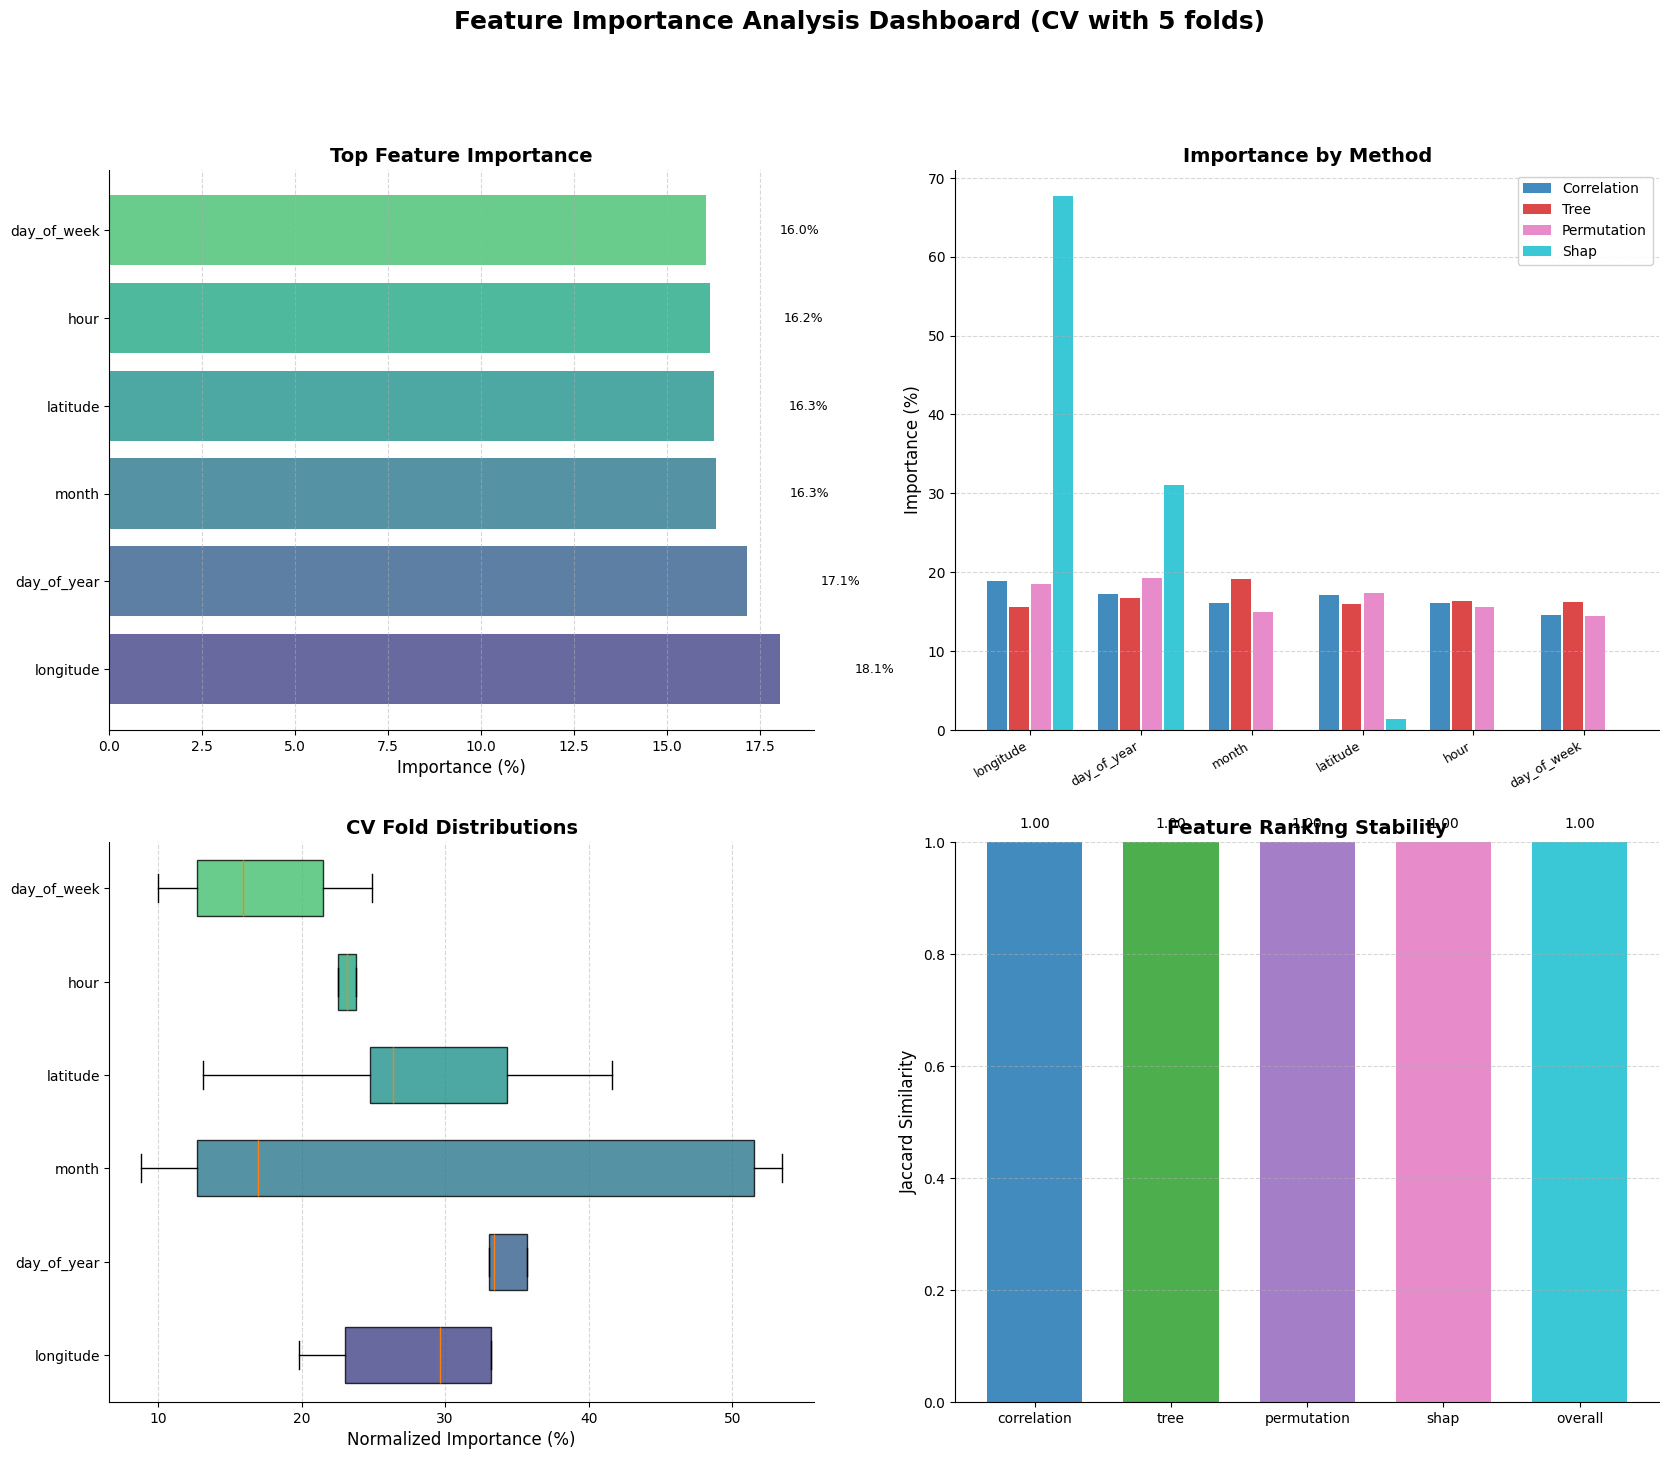

In [11]:
from tabularaml.inspect.importance import FeatureImportanceAnalyzer

analyzer = FeatureImportanceAnalyzer(cv = splitter, verbose=1, suppress_warnings=False)

analyzer.fit(X_train, y_train)

analyzer.plot_feature_importance_dashboard()

In [12]:
analyzer.get_importance(normalize=False).head(25)

,correlation_importance,tree_importance,permutation_importance,shap_importance,weighted_importance
day_of_year,0.661565,0.174486,0.249308,12.769825,1.330054
longitude,0.752491,0.104218,0.210713,13.550620,1.125936
month,0.593185,0.308524,-0.001877,1.602960,1.085434
latitude,0.653986,0.126655,0.146717,9.641099,0.981419
hour,0.594279,0.148321,0.034764,3.971078,0.741297
day_of_week,0.487703,0.137796,-0.039429,2.601516,0.543747


In [11]:
model = generator.baseline_model
model.fit(X_train, y_train)
preds = model.predict(X_test)
submission_df = pd.DataFrame({'id': test_df['id'], 'pollution_value': preds})
submission_df.to_csv("submission_hybrid_0_64856_irreproducible_0_63596.csv", index=False)

In [12]:
submission_df["pollution_value"]

0        9.396998
1       51.983631
2       10.956976
3       23.773220
4       22.782419
          ...    
2734    70.221130
2735    41.656448
2736    25.121187
2737     2.020109
2738    48.905235
Name: pollution_value, Length: 2739, dtype: float32